# CSS Lab: Networks
This lab demonstrates how to use common tools to analyze the structure of several networks. Topics covered include visualization, centrality measures, shortest paths, and affiliation networks. At the end of the lab, you will be able to visualze and perform an analysis of your own social network.

__NOTE:__ When running this lab in Azure Notebooks, it must be run in Jupyter Notebook by selecting the "Help" > "Launch Classic Notebook" menu.

## Contents

1. [Background](#Section-1%3A-Background)
2. [Setup](#Section-2%3A-Setup)
3. [Build and Visualize a Network](#Section-3%3A-Build-and-Visualize-a-Network)
    * [3.1 Load the Network](#3.1-Load-the-Network)
    * [3.2 Visualize the Network](#3.2-Visualize-the-Network)
4. [Centrality measures](#Section-4%3A-Centrality-Measures)
    * [4.1 Load the Network](#4.1-Load-the-Network)
    * [4.2 Visualize the Network](#4.2-Visualize-the-Network)
    * [4.3 Find Centrality](#4.3-Find-Centrality)
    * [4.4 Compare Centrality Measures](#4.4-Compare-Centrality-Measures)
5. [Your Social Network](#Section-5%3A-Your-Social-Network)
    * [5.1 Visualize Your Social Network](#5.1-Visualize-Your-Social-Network)
    * [5.2 Social Network Centrality](#5.2-Social-Network-Centrality)
6. [Reflection](#Section-6%3A-Reflection)
7. [References](#References)
    


## Section 1: Background
Many types of social science data can be represented and analyzed as networks. This notebook looks at networks made that represent the relationships between people: social networks. Social networks play an important role in the spread of information across groups of people. One reason to study social networks is to better understand social movements, why they spread or fizzle out, and the structure of relationships that make up those movements. In this notebook, you will analyze two social networks from the American Revolution: one historical (New England revolutionary groups) (Healey2013), and one fictional (co-appearences in the musical _Hamilton_). You will also have a chance to analyze your own social network.

## Section 2: Setup
We import several libraries, including `networkx` for network algorithms, `pandas` for data processing, and `vis` for visualization. We also define some helper functions used by several of the sections in this notebook.

In [1]:
%pylab inline
from IPython.display import display, Javascript, HTML
import itertools
import json
import math
import urllib.request
import networkx as nx
import networkx as networkx
import networkx.algorithms as nxalg
import networkx.algorithms.community as nxcom
import networkx.readwrite as nxrw
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


The following cell imports `vis.js`, the visualization library used by this lab. If you experience any errors trying to create a visualization, you can try to uncomment the second `vis` line below by removing `//` and commenting out the first `vis` line by adding `//` to the beginning.

In [2]:
%%javascript
require.config({
    paths: {
        vis: 'vis-4.21.0/dist/vis'
//        vis: 'https://cdnjs.cloudflare.com/ajax/libs/vis/4.21.0/vis'
    }
});

<IPython.core.display.Javascript object>

Load custom CSS for `vis`.

In [3]:
HTML('<style>{}</style>'.format(open('custom.css').read()))

In [4]:
# Helper functions

# Standardize a vector to 0 mean and unit variance
def scale(v):
    return (v - v.mean()) / v.std()

# Return a data frame sorted by a node's centrality relative the mean of its centralities
def rel_centrality(df, measure, labels=dict()):
    name = 'rel_{}'.format(measure)
    return pd.DataFrame({
        name: scale(df[measure]) / df['mean_centrality'],
        "label": [labels.get(x, x) for x in df.index]
    })

def get_colors():
    phi = (1 + math.sqrt(5)) / 2
    color = []
    for i in range(1, 20):
        theta = phi * i * math.pi * 2
        x = 128 + math.floor(64*math.sin(theta))
        y = 128 + math.floor(64*math.cos(theta))
        color.append((x, x, y))
    return color

def visjs_network(
        nodes_list,
        edges_dict,
        node_size_field=None,
        node_size_multiplier=1,
        edge_width_field=None,
        edge_width=None,
        edge_arrow_to=None,
        edge_arrow_to_scale_factor=1,
        edge_smooth_enabled=False,
        edge_smooth_type="curvedCW",
        graph_id="vis-output"):
    
    # Configure nodes
    for node in nodes_list:
        if node_size_field is not None:
            node['size'] = node[node_size_field] * node_size_multiplier
        node['title'] = node['label']
        node['font'] = { 'size': 14 }
        node['shadow'] = True
    node_json = json.dumps(nodes_list)
    
    # Configure edges
    for edge in edges_dict:
        color = edge['color']
        edge['color'] = {
            'color': color
        }
    edge_json = json.dumps(edges_dict)

    js = Javascript("""
(function(element) {{
    require(['vis'], function(vis) {{
      // create an array with nodes
      var nodes = new vis.DataSet({});
      console.log(nodes)

      // create an array with edges
      var edges = new vis.DataSet({});
      console.log(edges)

      // create a network
      var id = 'container-' + {}
      element.append('<div style="width:800px;height:800px" id="' + id + '">hi</div>')
      var container = document.getElementById(id);
      element.append(container)
      var data = {{
        nodes: nodes,
        edges: edges
      }};
      var options = {{
          physics: {{
              enabled: false
          }},
          interaction: {{
              hover: true
          }}
      }};
      var network = new vis.Network(container, data, options);
    }})
}})(element);
    """.format(node_json, edge_json, graph_id))
    return js

def visualize_visjs(
        G, communities=None, colors=None, default_color="192,192,192",
        node_size_field="node_size", layout="spring", scale=500, pos=None,
        groups=None, weight=None, labels=dict(), title=""):
    # Get list of nodes and edges
    nodes = list(G.nodes())
    edges = list(G.edges())
    # Change node shapes for bipartite graph
    if groups is None:
        node_shapes = dict()
        node_sizes = dict()
        node_colors = dict()
    else:
        node_shapes = dict((n, "square") for n in groups)
        node_sizes = dict((n, 15) for n in groups)
        node_colors = dict((n, "192,128,0") for n in groups)
    # Per-node properties
    nodes_dict = dict((n, {
        "id": n,
        "label": labels.get(n, n),
        "node_size": node_sizes.get(n, 5),
        "shape": node_shapes.get(n, "dot")
        }) for n in nodes)
    # Generate a layout for the nodes
    edge_smooth_enabled = False
    edge_width = 4
    edge_arrow_scale = 2
    if communities is not None and pos is None:
        # Generate initial positions based on community
        phi = 3.14 / len(nodes)
        community_node = []
        # Create list of nodes and their communities
        for i, com in enumerate(sorted(communities, key=lambda x: len(x), reverse=True)):
            for node in com:
                community_node.append((i, node))
        # Sort by community and
        community_node = sorted(community_node)
        # Generate initial position by placing communities around a circle
        pos = dict((d[1], (math.cos(i*phi), math.sin(i*phi))) for i, d in enumerate(community_node))
    else:
        pos = None
    if layout == "circle":
        pos = nx.circular_layout(G, scale=scale)
    elif layout == "spring":
        pos = nx.spring_layout(G, k=3/math.sqrt(len(nodes)), scale=scale, pos=pos)
    else:
        edge_smooth_enabled = True
    # Assign position
    for n in nodes:
        nodes_dict[n]["x"] = pos[n][0]
        nodes_dict[n]["y"] = pos[n][1]
    # Calculate bounds for scaling
    x_min = min(pos.values(), key=lambda x: x[0])[0]
    x_max = max(pos.values(), key=lambda x: x[0])[0]
    y_min = min(pos.values(), key=lambda x: x[1])[1]
    y_max = max(pos.values(), key=lambda x: x[1])[1]
    x_range = x_max - x_min
    y_range = y_max - y_min
    max_range = max(x_range, y_range)
    # If we have communities, assign color based on community
    if colors is None:
        colors = ["{},{},{}".format(*c) for c in get_colors()]
    if communities is not None:
        for i, com in enumerate(sorted(communities, key=lambda x: len(x), reverse=True)):
            for node in com:
                try:
                    nodes_dict[node]["color"] = "rgba({},1)".format(colors[i])
                    nodes_dict[node]["color_index"] = i
                except IndexError:
                    nodes_dict[node]["color"] = "rgba({},1)".format(default_color)
    # Update color for bipartite nodes
    for node, node_attr in nodes_dict.items():
        if node in node_colors:
            node_attr["color"] = "rgba({},1)".format(node_colors[node])
    # Map node labels to contiguous ids
    node_map = dict(zip(nodes,range(len(nodes))))
    # Determine edge colors
    edge_colors_idx = {}
    for source, target in edges:
        source_color = nodes_dict[source].get("color_index", None)
        target_color = nodes_dict[target].get("color_index", None)
        if source_color == target_color and source_color is not None:
            edge_colors_idx[(source, target)] = source_color
    edge_colors = dict(
        (e,colors[c])
        for e, c in edge_colors_idx.items() if c < len(colors))
    # Per-edge properties, use contiguous ids to identify nodes
    edge_scale = math.ceil(max_range / 200)
    edges_dict = []
    for source, target, data in G.edges(data=True):
        edge = {
            "from": source,
            "to": target,
            "title":'test',
            "color": "rgba({},0.3)".format(edge_colors.get((source,target), default_color)),
            "edge_width_field": "value",
            "value": data.get("value", 1) * edge_scale
        }
        edges_dict.append(edge)
    # Convert nodes dict to node list
    nodes_list = [nodes_dict[n] for n in nodes]
    # Check for directed graph
    if G.__class__ == nx.classes.digraph.DiGraph:
        directed = True
    else:
        directed = False
    # Call visjs
    return visjs_network(
        nodes_list, edges_dict,
        node_size_field="node_size",
        node_size_multiplier=5.0,
        edge_width_field="value",
        edge_width=edge_width,
        edge_arrow_to=directed,
        edge_arrow_to_scale_factor=edge_arrow_scale,
        edge_smooth_enabled=edge_smooth_enabled,
        edge_smooth_type="curvedCW",
        graph_id=hash(title))


## Section 3: Build and Visualize a Network

This section loads network data from a file and explores its basic properties. 

In [5]:
# Helper functions

def load_hamilton_affiliation():
    B = nxrw.adjlist.read_adjlist("external/hamilton.csv", delimiter="; ", comments="%")
    return B

def load_hamilton(threshold=None):
    # Load the song-character affiliation network
    B = load_hamilton_affiliation()
    # Get list of songs from the file
    songs = set()
    with open("external/hamilton.csv") as f:
        f.readline()
        for row in f:
            songs.add(row.split("; ")[0])
    # Deduce list of charactes
    characters = set(B.nodes()) - songs
    # Project the affiliation network onto the set of characters
    G = nxalg.bipartite.projection.weighted_projected_graph(B, characters)
    # Threshold
    if threshold is not None:
        for s, t, data in list(G.edges(data=True)):
            if data["weight"] < threshold:
                G.remove_edge(s,t)
    return G

### 3.1 Load the Network

The next cell loads data from a file using the `networkx` library,
and displays a list of nodes in the network.
This example uses characters from the play _Hamilton_.

In [6]:
G_hamilton = load_hamilton()
sorted(G_hamilton.nodes())

['A. Burr',
 'A. Hamilton',
 'A. Schuyler',
 'C. Lee',
 'E. Schuyler',
 'G. Eaker',
 'G. Washington',
 'George III',
 'H. Mulligan',
 'J. Laurens',
 'J. Madison',
 'J. Reynolds',
 'Lafayette',
 'M. Reynolds',
 'P. Hamilton',
 'P. Schuyler',
 'S. Seabury',
 'T. Jefferson']

Now that you know the labels of the nodes, you can see which nodes are connected by an edge.
In this case, two nodes are connected by an edge if the corresponding characters have parts in at least one song together.
The next cell chooses a single node and prints a list of all the other nodes it's connected to.
These nodes are called its neighbors.

In [7]:
sorted(G_hamilton.neighbors('E. Schuyler'))

['A. Burr',
 'A. Hamilton',
 'A. Schuyler',
 'C. Lee',
 'G. Washington',
 'H. Mulligan',
 'J. Laurens',
 'Lafayette',
 'P. Hamilton',
 'P. Schuyler']

### 3.2 Visualize the Network
In these visualizations, each circle represents a node.
Edges between two nodes are represented by drawing a line between them.

There are many ways to draw a network.
One simple way is to space all the nodes evenly around a circle.

In [8]:
visualize_visjs(G_hamilton, layout="circle", title="Circular Layout Example")

<IPython.core.display.Javascript object>

Another common way to visualize a network is using a "force-directed" layout.
In a force-directed layout, nodes push away from each other, but edges act like springs pulling them back together.
As a result, nodes with many neighbors in common are pulled closer to each other.

In [9]:
visualize_visjs(G_hamilton, scale=2000, title="Force-Directed Layout Example")

<IPython.core.display.Javascript object>

#### Short Answer 1
What is one advantage of circular layouts over force-directed? What is one advantage of force-directed layouts? Which would you use to identify groups of friends in a 10000-node college social network, and why? Which would you use to create a reference for who is friends with whom in a 20 person class, and why?

🤔 Your answer here:

## Section 4: Centrality Measures

One benefit of representing data as a network is that the patterns of connections between nodes can reveal useful information.
Many standard techniques for investigating the structure of networks have been developed.

One of the simplest to consider is which nodes are most important.
But first, "important" has to be defined.
There are several common ways to measure importance, or _centrality_, of nodes in a nework.
This section examines several of the most popular.

While the _Hamilton_ network in the previous section is simple enough to be illustrative,
a historical data set better demonstrates how centrality measures can be applied to real-world networks.
This section uses historical data on affilations between organizers of the American Revolution,
taken from [Using Metadata to Find Paul Revere](https://kieranhealy.org/blog/archives/2013/06/09/using-metadata-to-find-paul-revere/).

In [10]:
# Helper functions

def load_revere_affiliation(
        url="https://raw.githubusercontent.com/kjhealy/revere/master/data/PaulRevereAppD.csv"):
    data = urllib.request.urlopen(url)
    df = pd.read_csv(data).set_index("Unnamed: 0")
    people = list(df.index)
    groups = list(df.columns)
    #
    B = nx.Graph()
    for column in df.columns:
        for row in df[df[column] == 1].index:
            B.add_edge(column, row)
    return people, groups, B

def load_revere(
        url="https://raw.githubusercontent.com/kjhealy/revere/master/data/PaulRevereAppD.csv",
        threshold=None, dual=False):
    # Load the affiliation network
    people, groups, B = load_revere_affiliation(url)
    # Project the affiliation network onto the set of people
    if dual:
        G = nxalg.bipartite.projection.weighted_projected_graph(B, groups)
    else:
        G = nxalg.bipartite.projection.weighted_projected_graph(B, people)
    # Threshold
    if threshold is not None:
        for s, t, data in list(G.edges(data=True)):
            if data["weight"] < threshold:
                G.remove_edge(s,t)
    # Copy "weight" data to "value" needed by visjs
    w = nx.get_edge_attributes(G, "weight")
    nx.set_edge_attributes(G, w, "value")
    return G

### 4.1 Load the Network
The next cell begins by loading the data into a `networkx` graph. As is, an analysis of the data will reveal Paul Revere to be highly central by all measures (Healey2013), so to make the example more interesting, let's assume Paul Revere had been on vacation and try to determine who might have notified the Massachusetts Provincial Congress of the impending attack in his place. To do so, we remove Paul Revere from the network. 

In [11]:
G_revere = load_revere()
people, groups, B_revere = load_revere_affiliation()
G_revere.remove_node('Revere.Paul')

### 4.2 Visualize the Network
The next cell visualizes the network. You can zoom in and out and hover over nodes to see their labels.

In [12]:
visualize_visjs(G_revere, scale=1500, title="American Revolution")

<IPython.core.display.Javascript object>

#### Short Answer  2
Looking at the visualization above, consider who in the network might be influential. Based on their network position only, who do you think would be good at spreading news within a community (pick 3)? Who do you think would be good at spreading information quickly to many different groups of people (pick 3)? How might each of these properties relate to an individual’s role in a social movement such as the American Revolution?

🤔 Your answer here:

### 4.3 Find Centrality
Now let's move on to examine the centralities. The next cell uses `networkx` to calculate node centralities and then stores them in a data frame. For each node we also calculate a mean centrality value.

In [13]:
df = pd.DataFrame({"id": G_revere.nodes(), "label": G_revere.nodes()}).set_index("id")
df['degree'] = pd.Series(nx.degree_centrality(G_revere))
df['betweenness'] = pd.Series(nx.betweenness_centrality(G_revere))
df['closeness'] = pd.Series(nx.closeness_centrality(G_revere))
df['eigenvector'] = pd.Series(nx.eigenvector_centrality(G_revere))

In [14]:
# Calculate mean of all centrality measures
df['mean_centrality'] = (
    scale(df['degree'])
    + scale(df['betweenness'])
    + scale(df['closeness'])
    + scale(df['eigenvector'])) / 4.0

#### Degree

One very simple way to find important nodes is to count how many neighbors they have.
This measure is called the degree centrality.
This number is typically divided by the total number of other nodes in the network, so a value
of 0.82 means that a node is connected to 82% of the other nodes.
The next cell shows the nodes with the highest degree centralities.

Note that some of the people have the same degree. In fact, if two people have exactly the same set of neighbors,
all of their centrality scores will be the same.

In [15]:
df.sort_values('degree', ascending=False).head(5)

,label,degree,betweenness,closeness,eigenvector,mean_centrality
id,,,,,,
Chase.Thomas,Chase.Thomas,0.761905,0.041932,0.807692,0.120804,3.161785
Bass.Henry,Bass.Henry,0.761905,0.041932,0.807692,0.120804,3.161785
Barber.Nathaniel,Barber.Nathaniel,0.761905,0.036101,0.807692,0.121012,3.040089
Urann.Thomas,Urann.Thomas,0.753968,0.106664,0.802548,0.112889,4.438730
Proctor.Edward,Proctor.Edward,0.738095,0.029725,0.792453,0.120491,2.786450


#### Betweenness

Rather than highly-connected nodes, you might want to find nodes that connect different parts of the network.
These types of nodes are sometimes called bridges, or brokers.
The betweenness centrality is based on finding the shortest path between nodes.
The nodes on that path play the role of bridges, connecting the endpoints.
So the betweenness is the fraction of all shortest paths in the network that pass through a given node.

In [16]:
df.sort_values('betweenness', ascending=False).head(5)

,label,degree,betweenness,closeness,eigenvector,mean_centrality
id,,,,,,
Urann.Thomas,Urann.Thomas,0.753968,0.106664,0.802548,0.112889,4.438730
Warren.Joseph,Warren.Joseph,0.662698,0.102033,0.747774,0.046124,3.496944
Peck.Samuel,Peck.Samuel,0.575397,0.065971,0.701950,0.098779,2.687323
Bass.Henry,Bass.Henry,0.761905,0.041932,0.807692,0.120804,3.161785
Chase.Thomas,Chase.Thomas,0.761905,0.041932,0.807692,0.120804,3.161785


#### Closeness

A nodes might also be considered important if it is close to many other nodes.
In other words, if the paths connecting it to other nodes are all very short.
This measure is called closeness centrality.

In [17]:
df.sort_values('closeness', ascending=False).head(5)

,label,degree,betweenness,closeness,eigenvector,mean_centrality
id,,,,,,
Chase.Thomas,Chase.Thomas,0.761905,0.041932,0.807692,0.120804,3.161785
Bass.Henry,Bass.Henry,0.761905,0.041932,0.807692,0.120804,3.161785
Barber.Nathaniel,Barber.Nathaniel,0.761905,0.036101,0.807692,0.121012,3.040089
Urann.Thomas,Urann.Thomas,0.753968,0.106664,0.802548,0.112889,4.438730
Proctor.Edward,Proctor.Edward,0.738095,0.029725,0.792453,0.120491,2.786450


#### Eigenvector

The last centrality measure covered in this section measures not just how well-connected a node is, but how well-connected its neighbors are as well.
This measure is the eigenvector centrality.
The PageRank algorithm used by Google to find high quality websites is an extension of this algorithm.

In [18]:
df.sort_values('eigenvector', ascending=False).head(5)

,label,degree,betweenness,closeness,eigenvector,mean_centrality
id,,,,,,
Barber.Nathaniel,Barber.Nathaniel,0.761905,0.036101,0.807692,0.121012,3.040089
Bass.Henry,Bass.Henry,0.761905,0.041932,0.807692,0.120804,3.161785
Chase.Thomas,Chase.Thomas,0.761905,0.041932,0.807692,0.120804,3.161785
Condy.JamesFoster,Condy.JamesFoster,0.738095,0.029725,0.792453,0.120491,2.786450
Proctor.Edward,Proctor.Edward,0.738095,0.029725,0.792453,0.120491,2.786450


#### Short Answer 3
Looking over the above centrality results, write a few sentences addressing the following questions. Where do the high centrality individuals appear in visualization? For each type of centrality, are there any individuals who appear in that list but not in others? Which of the lists, if any, did your predictions from the previous question appear in?

🤔 Your answer here:

### 4.4 Compare Centrality Measures

The following plot shows how different centrality measures are related to each other (in this network).
Each graph compares two centrality measures corresponding to its row and column.
In each graph, each point represents a single node in the network.

Points are drawn with transparency so overlapping points are darker.
If a group of people have the same centralities,
possibly because they have the same set of neighbors,
they appear as a single dark spot.

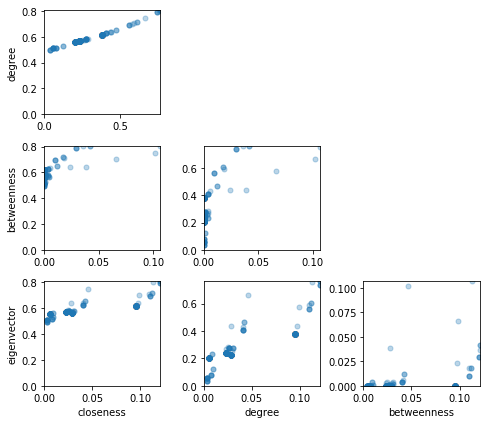

In [19]:
# Store column names in array to keep order consistent
measures = ["degree", "betweenness", "eigenvector", "closeness"]
plt.figure(figsize=(7,6))
# Loop through rows and columns
# Even though we have 4 measures, we only need 3x3 to compare all
for row in range(3):
    for col in range(3):
        # Each row column pair only needs to be plotted once
        if row >= col:
            # The longest row should correspond to the measure that
            # does not appear on a column.
            x, y = df[measures[row]], df[measures[(col-1) % 4]]
            plt.subplot(3,3,1 + row*3 + col)
            plt.plot(x, y, '.', alpha=0.3, markersize=10)
            plt.xlim([0, x.max()]); plt.ylim([0, y.max()])
        if row == 2:
            plt.xlabel(measures[(col - 1) % 4])
        if col == 0:
            plt.ylabel(measures[row])
plt.tight_layout()

## Section 5: Your Social Network
Now you can do these analyses on your own social network! Specifically, you can download a list of all of your friends and whether they are friends with each other.
This network is called your "ego network."

If you use Facebook, you can use the LostCircles plugin for Chrome to download your social network.
1. Open the following link in Chrome to install LostCircles:
https://chrome.google.com/webstore/detail/lost-circles-facebook-gra/ehpmfdlcppenimpibdifodjgfafkjhjl?hl=en
2. Click the LostCircles icon on the Chrome toolbar and select "Start Loading."
3. Wait until the menu shows "100%" next to "Start Loading."
4. Click the LostCircles icon and then "Download..." followed by "JSON (no pics)". Save the result as `external/LostCircles/egonet.json`.
5. Continue to the next cell

In [20]:
# Helper functions

def load_lost_circles_json(in_file, name=False):
    with open(in_file) as f:
        raw = json.load(f)
    id_to_name = dict((i, datum["name"]) for i, datum in enumerate(raw['nodes']))
    if name:
        edges = [(id_to_name[datum["source"]], id_to_name[datum["target"]], {"capacity":1}) for datum in raw['links']]
    else:
        edges = [(datum["source"], datum["target"], {"capacity":1}) for datum in raw['links']]
    G = nx.Graph()
    G.add_edges_from(edges)
    return G, id_to_name, edges

### 5.1 Visualize Your Social Network
The cell below will visualize your ego network and label each node with a name. In order to protect your friends' privacy and remove their names, remove the `#` from the third line and re-run the cell before submitting your work.

In [ ]:
G_ego, id_to_name, edges = load_lost_circles_json("external/LostCircles/egonet.json")
visualize_visjs(G_ego, title="Ego Net", scale=6000, labels=id_to_name)
#visualize_visjs(G_ego, title="Ego Net", scale=6000)

<IPython.core.display.Javascript object>

#### Short Answer 4
Using the visualization above, write a few sentences answering the following questions. About what fraction of your friends have a friend in common with you? Do you see any sets of 3 people who are all friends with each other? Do you think such triangles are more common or less common than they would be if the same number of friendships were assigned randomly? Why or why not? Think about who you would give a message to if you wanted to reach all your friends but could only tell one person. Looking at the visualization, does that person stand out for any reason? If so, how? If not, why do you think this information isn’t captured in the visualization?

🤔 Your answer here:

### 5.2 Social Network Centrality
Now you can repeat the centrality analysis for members of your own ego network.

In [ ]:
# Calculate centrality measures
df = pd.DataFrame({"id": G_ego.nodes(), "label": [id_to_name[x] for x in G_ego.nodes()]}).set_index("id")
df['degree'] = pd.Series(nx.degree_centrality(G_ego))
df['betweenness'] = pd.Series(nx.betweenness_centrality(G_ego))
df['closeness'] = pd.Series(nx.closeness_centrality(G_ego))
df['eigenvector'] = pd.Series(nx.eigenvector_centrality(G_ego))
# Calculate mean of all centrality measures
df['mean_centrality'] = (
    scale(df['degree'])
    + scale(df['betweenness'])
    + scale(df['closeness'])
    + scale(df['eigenvector'])) / 4.0

#### Degree
These are the most highly connected members of your network.

In [ ]:
df.sort_values('degree', ascending=False).head(5)

#### Betweenness
These are the individuals who connect different parts of your network.

In [ ]:
df.sort_values('betweenness', ascending=False).head(5)

#### Closeness
These individuals are, on average, closest to everyone you know.

In [ ]:
df.sort_values('closeness', ascending=False).head(5)

#### Eigenvector
These individuals are most highly connected to other highly connected individuals.

In [ ]:
df.sort_values('eigenvector', ascending=False).head(5)

## Section 6: Reflection

#### Reflection Question 1
A network is defined by only by the number of nodes and by which nodes are connected to each other. Give an example of a type of information that gets left out when constructing a social network. Explain one benefit and one drawback of leaving that information out.

🤔 Your answer here:

#### Reflection Question 2
Consider how your friendship network changes over time based on your actions. If you wanted to increase your degree centrality, what types of activities would you do? What if you wanted to increase your betweenness centrality?

🤔 Your answer here:

#### Reflection Question 3
Consider your friendship ego network. Give an example of something new you learned from seeing this "bird’s eye view" of your network. Give an example of something important about your social group that you can’t learn from looking at only the network.

🤔 Your answer here:

## References

(Healey2013) Healy, K. 2013. "Using Metadata to Find Paul Revere." https://kieranhealy.org/blog/archives/2013/06/09/using-metadata-to-find-paul-revere/